In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/__MACOSX/MontgomerySet/._NLM-MontgomeryCXRSet-ReadMe.pdf
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/__MACOSX/MontgomerySet/._.DS_Store
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/__MACOSX/MontgomerySet/ManualMask/._.DS_Store
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/__MACOSX/MontgomerySet/ManualMask/leftMask/._Thumbs.db
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/__MACOSX/MontgomerySet/CXR_png/._Thumbs.db
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/.DS_Store
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/NLM-MontgomeryCXRSet-ReadMe.pdf
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/.DS_Store
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/MCUCXR_0075_0.png
/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/Montgo

In [2]:
import glob
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style

from tqdm  import tqdm
from keras import backend as K
from sklearn.metrics     import accuracy_score, roc_auc_score
from keras.layers        import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D
from keras.models        import Sequential, Model, load_model
from keras.callbacks     import ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from keras.activations   import elu
from keras.engine        import Layer, InputSpec
from keras.optimizers    import Adam
from keras.preprocessing import image
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator


In [3]:
import os
os.listdir('../input/pulmonary-chest-xray-abnormalities')

['Montgomery', 'ChinaSet_AllFiles']

In [4]:
china_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

In [5]:
df_c = pd.DataFrame(china_list, columns=['image_id'])
df_m = pd.DataFrame(mont_list, columns=['image_id'])
print(df_m.head())
df_c = df_c[df_c['image_id'] != 'Thumbs.db'] #check
df_m = df_m[df_m['image_id'] != 'Thumbs.db']
df_c.reset_index(inplace=True, drop=True)
df_m.reset_index(inplace=True, drop=True)

print(df_c.shape)
print(df_m.shape)

            image_id
0  MCUCXR_0075_0.png
1  MCUCXR_0069_0.png
2  MCUCXR_0058_0.png
3  MCUCXR_0203_1.png
4  MCUCXR_0338_1.png
(662, 1)
(138, 1)


In [6]:
df_c.head()


,image_id
0,CHNCXR_0642_1.png
1,CHNCXR_0288_0.png
2,CHNCXR_0514_1.png
3,CHNCXR_0644_1.png
4,CHNCXR_0540_1.png


In [7]:
def find(x):
    i = int(x[-5])
    if i == 0:
        return 'Normal'
    if i == 1:
        return 'Tuberculosis'

In [8]:
df_c['target'] = df_c['image_id'].apply(find)
df_m['target'] = df_m['image_id'].apply(find)

In [9]:
print(df_c['target'].value_counts())
print(df_m['target'].value_counts())
#concatenate 
df_total = pd.concat([df_c, df_m], axis=0).reset_index(drop=True)
#shuffling data
df_total = df_total.sample(frac=1)


Tuberculosis    336
Normal          326
Name: target, dtype: int64
Normal          80
Tuberculosis    58
Name: target, dtype: int64


In [10]:
df_total.head()

,image_id,target
9,CHNCXR_0182_0.png,Normal
762,MCUCXR_0079_0.png,Normal
207,CHNCXR_0579_1.png,Tuberculosis
554,CHNCXR_0355_1.png,Tuberculosis
113,CHNCXR_0437_1.png,Tuberculosis


In [11]:
df_total = pd.get_dummies(df_total, columns=['target'])
df_total.head()

,image_id,target_Normal,target_Tuberculosis
9,CHNCXR_0182_0.png,1,0
762,MCUCXR_0079_0.png,1,0
207,CHNCXR_0579_1.png,0,1
554,CHNCXR_0355_1.png,0,1
113,CHNCXR_0437_1.png,0,1


In [12]:
df_total=df_total.drop(columns=['target_Tuberculosis'])
df_total = df_total.rename(columns={'target_Normal': 'label'})
print(df_total.head())

              image_id  label
9    CHNCXR_0182_0.png      1
762  MCUCXR_0079_0.png      1
207  CHNCXR_0579_1.png      0
554  CHNCXR_0355_1.png      0
113  CHNCXR_0437_1.png      0


In [13]:
startifyparameter = df_total['label']
#startify splits data in proportion of startify parameter
df_train, df_val = train_test_split(df_total, test_size=0.12, random_state=42, stratify= startifyparameter)

print(df_train.shape)
print(df_val.shape)

(704, 2)
(96, 2)


In [14]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)

Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)

In [15]:
df_total.set_index('image_id', inplace=True)

In [16]:
import cv2
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_total.loc[image,'label']
    if label == 1:
        label= 'Normal'
    else:
        label= 'Tuberculosis'
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (96,96))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (96,96))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination


for image in val_list:
    
    fname = image
    label = df_total.loc[image,'label']
    if label == 1:
        label= 'Normal'
    else:
        label= 'Tuberculosis'
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (96,96))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (96,96))
        # save the image at the destination
        cv2.imwrite(dst, image)
        

In [17]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

357
347


In [18]:
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

49
47


In [19]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory('base_dir/train_dir',
                                        target_size=(96,96),
                                        batch_size= 10,
                                        class_mode='categorical',
                                        follow_links=True)

val_gen = datagen.flow_from_directory('base_dir/val_dir',
                                        target_size=(96,96),
                                        batch_size= 10,
                                        class_mode='categorical',
                                        follow_links =True)


Found 704 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [20]:
cnn = keras.models.Sequential()

In [21]:
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[96, 96, 3]))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.3))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.25))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.23))

In [22]:
cnn.add(Flatten())

In [23]:
cnn.add(keras.layers.Dense(units=256, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(keras.layers.Dense(units=2, activation = "softmax"))

In [24]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0

In [25]:
cnn.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
my_callbacks = [keras.callbacks.EarlyStopping(patience=5)]

In [26]:
history = cnn.fit(x = train_gen, validation_data = val_gen, epochs = 50 , batch_size=12 , callbacks=my_callbacks, verbose=1)


Epoch 1/50
71/71 [==============================] - 14s 192ms/step - loss: 0.6994 - accuracy: 0.4801 - val_loss: 0.6894 - val_accuracy: 0.5521
Epoch 2/50
71/71 [==============================] - 13s 180ms/step - loss: 0.6890 - accuracy: 0.5455 - val_loss: 0.6866 - val_accuracy: 0.7500
Epoch 3/50
71/71 [==============================] - 13s 181ms/step - loss: 0.6819 - accuracy: 0.5540 - val_loss: 0.6779 - val_accuracy: 0.5000
Epoch 4/50
71/71 [==============================] - 13s 186ms/step - loss: 0.6591 - accuracy: 0.6278 - val_loss: 0.6364 - val_accuracy: 0.7188
Epoch 5/50
71/71 [==============================] - 13s 187ms/step - loss: 0.6427 - accuracy: 0.6562 - val_loss: 0.6102 - val_accuracy: 0.6979
Epoch 6/50
71/71 [==============================] - 13s 182ms/step - loss: 0.6030 - accuracy: 0.6889 - val_loss: 0.5583 - val_accuracy: 0.7604
Epoch 7/50
71/71 [==============================] - 13s 178ms/step - loss: 0.5914 - accuracy: 0.6889 - val_loss: 0.5495 - val_accuracy: 0.7500

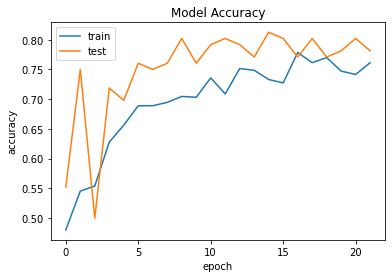

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()